# Лабораторная работа №4 “Нейронные сети”

# Задание

Набор данных ex4data1.mat (такой же, как в лабораторной работе №2) представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор содержит 5000 изображений 20x20 в оттенках серого. Каждый пиксель представляет собой значение яркости (вещественное число). Каждое изображение сохранено в виде вектора из 400 элементов. В результате загрузки набора данных должна быть получена матрица 5000x400. Далее расположены метки классов изображений от 1 до 9 (соответствуют цифрам от 1 до 9), а также 10 (соответствует цифре 0).

1. Загрузите данные ex4data1.mat из файла.
2. Загрузите веса нейронной сети из файла ex4weights.mat, который содержит две матрицы Θ(1) (25, 401) и Θ(2) (10, 26). Какова структура полученной нейронной сети?
3. Реализуйте функцию прямого распространения с сигмоидом в качестве функции активации. 
4. Вычислите процент правильных классификаций на обучающей выборке. Сравните полученный результат с логистической регрессией.
5. Перекодируйте исходные метки классов по схеме one-hot.
6. Реализуйте функцию стоимости для данной нейронной сети.
7. Добавьте L2-регуляризацию в функцию стоимости.
8. Реализуйте функцию вычисления производной для функции активации.
9. Инициализируйте веса небольшими случайными числами.
10. Реализуйте алгоритм обратного распространения ошибки для данной конфигурации сети.
11. Для того, чтобы удостоверится в правильности вычисленных значений градиентов используйте метод проверки градиента с параметром ε = 10-4.
12. Добавьте L2-регуляризацию в процесс вычисления градиентов.
13. Проверьте полученные значения градиента.
14. Обучите нейронную сеть с использованием градиентного спуска или других более эффективных методов оптимизации.
15. Вычислите процент правильных классификаций на обучающей выборке.
16. Визуализируйте скрытый слой обученной сети.
17. Подберите параметр регуляризации. Как меняются изображения на скрытом слое в зависимости от данного параметра?

In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

1. Загрузите данные ex4data1.mat из файла.

In [5]:
data = loadmat("Data/Lab 4/ex4data1.mat")
X, y = data["X"], data["y"].flatten()

print(X.shape, y.shape)

(5000, 400) (5000,)


2. Загрузите веса нейронной сети из файла ex4weights.mat, который содержит две матрицы Θ1 (25, 401) и Θ2 (10, 26). Какова структура полученной нейронной сети?

In [7]:
data = loadmat("Data/Lab 4/ex4weights.mat")
theta1, theta2 = data['Theta1'], data['Theta2']

print(theta1.shape, theta2.shape)

(25, 401) (10, 26)


Это двухслойный перцептрон (MLP).

3. Реализуйте функцию прямого распространения с сигмоидом в качестве функции активации. 

In [12]:
class Param:
    def __init__(self, value):
        self.value = value
        self.grad = np.zeros_like(value)
        

class DenseLayer:
    def __init__(self, W, B):
        self.W = Param(W)
        self.B = Param(B)
        self.X = None

    def forward(self, X):
        self.X = X
        result = self.X @ self.W.value + self.B.value

        return result

class Sigmoid:
    def forward(self, X):
        return 1. / (1. + np.exp(-X))

    
class Model:
    def __init__(self, W1, W2, B1, B2):
        self.fc1 = DenseLayer(W1, B1)
        self.fc2 = DenseLayer(W2, B2)
        self.activation = Sigmoid()
    
    def forward(self, X):
        predictions = self.fc1.forward(X)
        predictions = self.activation.forward(predictions)
        predictions = self.fc2.forward(predictions)
        
        return predictions
        
    def predict(self, X):
        predictions = self.forward(X)
        pred = np.argmax(predictions, axis=1)

        return pred

4. Вычислите процент правильных классификаций на обучающей выборке. Сравните полученный результат с логистической регрессией.

In [16]:
theta1_tr, theta2_tr = theta1.transpose(), theta2.transpose()
W1, W2 = theta1_tr[1:, :], theta2_tr[1:, :]
B1, B2 = theta1_tr[0, :], theta2_tr[0, :]

model = Model(W1, W2, B1, B2)

In [17]:
predictions = model.predict(X)

In [18]:
def accuracy(prediction, ground_truth):
    right_predictions = prediction == ground_truth
    accuracy = right_predictions.sum() / right_predictions.shape[0]

    return accuracy

In [20]:
shifted_classes = y - 1
accuracy(predictions, shifted_classes)

0.9752

Мультиклассовая точность сотавляет **0.9752** в сравнени с **0.9476** полученными с помощью линейной модели (one-vs-all логистической регресии). Замеры произведены на обучающей выборке. 

5. Перекодируйте исходные метки классов по схеме one-hot.

In [26]:
from sklearn.preprocessing import OneHotEncoder

label_encoder = OneHotEncoder(categories='auto')
y_one_hot = label_encoder.fit_transform(y.reshape(-1, 1)).toarray()
y_one_hot.shape

(5000, 10)

In [27]:
y_one_hot[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

6. Реализуйте функцию стоимости для данной нейронной сети.

In [36]:
def softmax_with_cross_entropy(predictions, target_index):
    # For stabilization
    predictions = predictions - np.max(predictions, axis=1)[:, np.newaxis]
    softmax_values = np.exp(predictions) / np.sum(np.exp(predictions), axis=1)[:, np.newaxis]

    loss = -np.log(softmax_values[range(softmax_values.shape[0]), target_index])
    loss = np.sum(loss)

    prediction_grad = softmax_values
    prediction_grad[range(prediction_grad.shape[0]), target_index] -= 1

    return loss, prediction_grad

In [38]:
loss, grad = softmax_with_cross_entropy(model.forward(X), y_one_hot.argmax(axis=1))
loss, grad[0]

(434.443764480019,
 array([ 4.82663458e-07,  7.47213968e-06,  1.08522227e-05,  7.88355204e-08,
         4.04858629e-05,  1.71721350e-05,  2.37564202e-05,  1.72046278e-06,
         2.79426125e-05, -1.29963355e-04]))

7. Добавьте L2-регуляризацию в функцию стоимости.

In [39]:
def l2_regularization(W, reg_lambda):
    loss = reg_lambda * np.sum(W**2)
    grad = reg_lambda * 2 * W

    return loss, grad

8. Реализуйте функцию вычисления производной для функции активации.

In [43]:
class Sigmoid:
    def __init__(self):
        self.value = None

    def forward(self, X):
        self.value = 1. / (1. + np.exp(-X))
        return self.value 
    
    def backward(self, d_out):
        # Sigmoid derivative
        d_sigmoid = (1. - self.value) * self.value
        # Chain rule
        return d_out * d_sigmoid

    def params(self):
        # Sigmoid Doesn't have any parameters
        return {}
    

class DenseLayer:
    def __init__(self, W, B):
        self.W = Param(W)
        self.B = Param(B)
        
        self.X = None

    def forward(self, X):
        self.X = X
        result = self.X @ self.W.value + self.B.value

        return result
    
    def backward(self, d_out):
        d_input = d_out @ self.W.value.T

        self.W.grad = self.X.T @ d_out
        self.B.grad = np.sum(d_out, axis=0) * np.ones_like(self.B.value)

        return d_input

    def params(self):
        return {'W': self.W, 'B': self.B}

9. Инициализируйте веса небольшими случайными числами.

In [49]:
W1_init = np.random.randn(400, 25)
W2_init = np.random.randn(25, 10)
B1_init = np.random.randn(25)
B2_init = np.random.randn(10)

10. Реализуйте алгоритм обратного распространения ошибки для данной конфигурации сети.

In [50]:
class Model:
    def __init__(self, W1, W2, B1, B2, reg_lambda):
        self.fc1 = DenseLayer(W1, B1)
        self.sigmoid = Sigmoid()
        self.fc2 = DenseLayer(W2, B2)
        self.reg = reg_lambda
           
    def forward(self, X):
        predictions = self.fc1.forward(X)
        predictions = self.sigmoid.forward(predictions)
        predictions = self.fc2.forward(predictions)
        
        return predictions
        
    def predict(self, X):
        predictions = self.forward(X)
        pred = np.argmax(predictions, axis=1)

        return pred
    
    def compute_loss_and_gradients(self, X, y):
        # Like in PyTorch: clean gradients for all layers
        for param in self.params().values():
            param.grad = np.zeros_like(param.grad)

        predictions = self.forward(X)
        cross_entropy_loss, dpredictions = softmax_with_cross_entropy(predictions, y)
        
        # Backward:
        dpredictions = self.fc2.backward(dpredictions)
        dpredictions = self.sigmoid.backward(dpredictions)
        dpredictions = self.fc1.backward(dpredictions)
        dX = dpredictions

        total_regularization_loss = 0
        for param in self.params().values():
            l2_loss, l2_grad = l2_regularization(param.value, self.reg)

            param.grad += l2_grad
            total_regularization_loss += l2_loss

        loss = cross_entropy_loss + total_regularization_loss

        return loss

    def params(self):
        result = {
            'W1': self.fc1.W,
            'B1': self.fc1.B,
            'W2': self.fc2.W,
            'B2': self.fc2.B
        }

        return result

11. Для того, чтобы удостоверится в правильности вычисленных значений градиентов используйте метод проверки градиента с параметром ε = 10^(-4).

In [66]:
def check_gradient(f, x, delta, tol):
    assert isinstance(x, np.ndarray)
    assert x.dtype == np.float
    
    orig_x = x.copy()
    fx, analytic_grad = f(x)
    assert np.all(np.isclose(orig_x, x, tol)), "Functions shouldn't modify input variables"

    assert analytic_grad.shape == x.shape
    analytic_grad = analytic_grad.copy()

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        analytic_grad_at_ix = analytic_grad[ix]

        h = np.zeros_like(x)
        h[ix] += 1

        numeric_grad_at_ix = (f(x + delta*h)[0] - f(x - delta*h)[0]) / (2 * delta)

        if not np.isclose(numeric_grad_at_ix, analytic_grad_at_ix, tol):
            print("Gradients are different at %s. Analytic: %2.5f, Numeric: %2.5f" % (ix, analytic_grad_at_ix, numeric_grad_at_ix))
            return False

        it.iternext()

    print("Gradient check passed!")
    return True


def check_model_gradient(model, X, y, delta, eps):
    params = model.params()

    for param_key in params:
        print("Checking gradient for %s" % param_key)
        param = params[param_key]
        initial_w = param.value

        def helper_func(w):
            param.value = w
            loss = model.compute_loss_and_gradients(X, y)
            grad = param.grad
            return loss, grad

        if not check_gradient(helper_func, initial_w, delta, eps):
            return False

    return True

In [67]:
model = Model(W1_init, W2_init, B1_init, B2_init, reg_lambda=0)

In [69]:
batch_size = 1
assert check_model_gradient(
    model, 
    X[:batch_size], 
    y_one_hot.argmax(axis=1)[:batch_size],
    delta=1e-6,
    eps=1e-4
)

Checking gradient for W1
Gradient check passed!
Checking gradient for B1
Gradient check passed!
Checking gradient for W2
Gradient check passed!
Checking gradient for B2
Gradient check passed!


12. Добавьте L2-регуляризацию в процесс вычисления градиентов.

In [70]:
model = Model(W1_init, W2_init, B1_init, B2_init, reg_lambda=1e-2)

13. Проверьте полученные значения градиента.

In [72]:
batch_size = 1

assert check_model_gradient(
    model, 
    X[:batch_size], 
    y_one_hot.argmax(axis=1)[:batch_size],
    delta=1e-6,
    eps=1e-4
)

Checking gradient for W1
Gradient check passed!
Checking gradient for B1
Gradient check passed!
Checking gradient for W2
Gradient check passed!
Checking gradient for B2
Gradient check passed!


14. Обучите нейронную сеть с использованием градиентного спуска или других более эффективных методов оптимизации.

In [76]:
from copy import deepcopy

class GradientDescent:
    
    def update(self, w, d_w, learning_rate):
        return w - d_w * learning_rate

class Trainer:

    def __init__(self, model, train_X, train_y, optim,
                 num_epochs=20,
                 batch_size=20,
                 learning_rate=1e-2):
        self.train_X, self.train_y = train_X, train_y
        self.model = model
        self.optim = optim
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

        self.optimizers = None

    def setup_optimizers(self):
        params = self.model.params()
        self.optimizers = {}
        for param_name, param in params.items():
            self.optimizers[param_name] = deepcopy(self.optim)

    def compute_accuracy(self, X, y):
        indices = np.arange(X.shape[0])
        sections = np.arange(self.batch_size, X.shape[0], self.batch_size)
        batches_indices = np.array_split(indices, sections)

        pred = np.zeros_like(y)

        for batch_indices in batches_indices:
            batch_X = X[batch_indices]
            pred_batch = self.model.predict(batch_X)
            pred[batch_indices] = pred_batch

        return accuracy(pred, y)

    def fit(self):
        if self.optimizers is None:
            self.setup_optimizers()

        num_train = self.train_X.shape[0]

        loss_history = []
        train_acc_history = []
        val_acc_history = []
        
        for epoch in range(self.num_epochs):
            shuffled_indices = np.arange(num_train)
            np.random.shuffle(shuffled_indices)
            sections = np.arange(self.batch_size, num_train, self.batch_size)
            batches_indices = np.array_split(shuffled_indices, sections)

            batch_losses = []

            for batch_indices in batches_indices:
                x_batch, y_batch = self.train_X[batch_indices], self.train_y[batch_indices]
                loss = self.model.compute_loss_and_gradients(x_batch, y_batch)

                for param_name, param in self.model.params().items():
                    optimizer = self.optimizers[param_name]
                    param.value = optimizer.update(param.value, param.grad, self.learning_rate)

                batch_losses.append(loss)

                batch_accuracy = self.compute_accuracy(x_batch, y_batch)

            ave_loss = np.mean(batch_losses)
            train_accuracy = self.compute_accuracy(self.train_X, self.train_y)

            print("Loss: %f, Train accuracy: %f" %(batch_losses[-1], train_accuracy))

            loss_history.append(ave_loss)
            train_acc_history.append(train_accuracy)

        return loss_history, train_acc_history

In [80]:
model = Model(W1_init, W2_init, B1_init, B2_init, reg_lambda=1e-4)

optim = GradientDescent()
trainer = Trainer(model=model, train_X=X, train_y=y_one_hot.argmax(axis=1), optim=optim, num_epochs=100)

In [81]:
loss_history, train_acc_history = trainer.fit()

Loss: 21.622835, Train accuracy: 0.660000
Loss: 11.862946, Train accuracy: 0.773400
Loss: 10.669136, Train accuracy: 0.820200
Loss: 10.924210, Train accuracy: 0.845400
Loss: 8.804628, Train accuracy: 0.858000
Loss: 6.415286, Train accuracy: 0.871800
Loss: 8.063940, Train accuracy: 0.878200
Loss: 7.015385, Train accuracy: 0.894000
Loss: 9.713760, Train accuracy: 0.896600
Loss: 10.280374, Train accuracy: 0.903600
Loss: 4.761142, Train accuracy: 0.910000
Loss: 6.358284, Train accuracy: 0.915600
Loss: 5.359264, Train accuracy: 0.917000
Loss: 9.868103, Train accuracy: 0.921600
Loss: 3.395206, Train accuracy: 0.923800
Loss: 4.569061, Train accuracy: 0.926600
Loss: 16.916341, Train accuracy: 0.931000
Loss: 4.361866, Train accuracy: 0.929200
Loss: 4.327137, Train accuracy: 0.935000
Loss: 3.103201, Train accuracy: 0.936400
Loss: 4.422709, Train accuracy: 0.937400
Loss: 3.914099, Train accuracy: 0.941000
Loss: 5.108273, Train accuracy: 0.941800
Loss: 3.082111, Train accuracy: 0.945800
Loss: 3.40

15. Вычислите процент правильных классификаций на обучающей выборке.

In [82]:
train_acc_history[-1]

0.9924

16. Визуализируйте скрытый слой обученной сети.

In [84]:
W1_trained = model.fc1.W.value
W1_trained.shape

(400, 25)

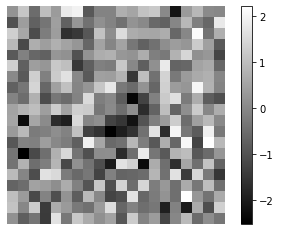

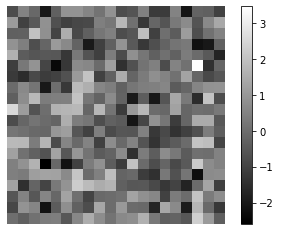

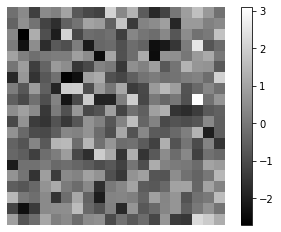

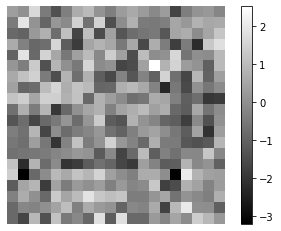

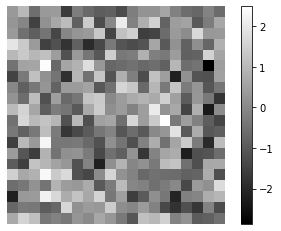

In [85]:
W1_trained_reshaped = W1_trained.reshape((20, 20, 25)).transpose()

for W in W1_trained_reshaped[:5]:
    plt.imshow(W.transpose(), cmap="gray")
    plt.axis('off')
    plt.colorbar()
    plt.show()

Значимость весов похожа на случайный шум - может свидетельствовать о переобучении на артефакты изображений

17. Подберите параметр регуляризации. Как меняются изображения на скрытом слое в зависимости от данного параметра?

In [86]:
model = Model(W1_init, W2_init, B1_init, B2_init, reg_lambda=1e-2)
trainer = Trainer(model=model, train_X=X, train_y=y_one_hot.argmax(axis=1), optim=optim, num_epochs=100)

In [87]:
loss_history, train_acc_history = trainer.fit()

Loss: 116.832649, Train accuracy: 0.677600
Loss: 96.663947, Train accuracy: 0.788200
Loss: 85.541898, Train accuracy: 0.827600
Loss: 76.434295, Train accuracy: 0.852400
Loss: 74.809092, Train accuracy: 0.876000
Loss: 63.974814, Train accuracy: 0.886000
Loss: 58.834783, Train accuracy: 0.898600
Loss: 61.135704, Train accuracy: 0.902600
Loss: 49.236146, Train accuracy: 0.910000
Loss: 46.128037, Train accuracy: 0.916000
Loss: 43.055121, Train accuracy: 0.921000
Loss: 37.766359, Train accuracy: 0.923800
Loss: 35.176353, Train accuracy: 0.924600
Loss: 34.127021, Train accuracy: 0.929400
Loss: 33.972702, Train accuracy: 0.935200
Loss: 30.857966, Train accuracy: 0.936600
Loss: 23.609338, Train accuracy: 0.940000
Loss: 23.799835, Train accuracy: 0.941000
Loss: 23.296994, Train accuracy: 0.941800
Loss: 19.418395, Train accuracy: 0.943800
Loss: 20.716135, Train accuracy: 0.945000
Loss: 17.477663, Train accuracy: 0.946200
Loss: 22.135035, Train accuracy: 0.947200
Loss: 15.030756, Train accuracy: 

In [88]:
W1_trained = model.fc1.W.value
W1_trained.shape

(400, 25)

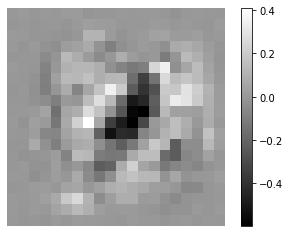

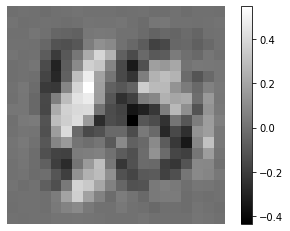

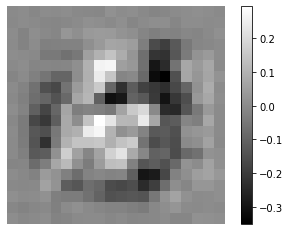

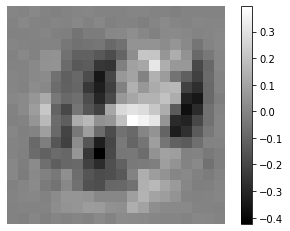

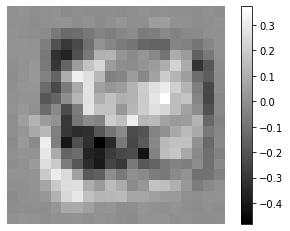

In [90]:
W1_trained_reshaped = W1_trained.reshape((20, 20, 25)).transpose()

for W in W1_trained_reshaped[:5]:
    plt.imshow(W.transpose(), cmap="gray")
    plt.axis('off')
    plt.colorbar()
    plt.show()

При регуляризации весов визуализации получаются более "сконцентрированными" - те каждый нейрон фокусируется выучивать какую-то особенность входного изображения.